# Imports

In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from zipfile import ZipFile
from PIL import Image
import matplotlib.pyplot as plt

from nltk.translate.bleu_score import corpus_bleu

import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [2]:
DATASET_DIR = 'drive/MyDrive/Colab Data/Datasets'
MODEL_DIR = 'drive/MyDrive/Colab Data/Models/VGG16_LSTM_Arabic'
FEATURES_DIR = 'drive/MyDrive/Colab Data/Pretrained Features/VGG16'

# Extract Image Features

In [3]:
# Load VGG16 model
model = VGG16()
# remove last layer of model because we only need the previous layers that extract image features
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

553467096/553467096 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [ ]:
# extract features from image
with ZipFile(DATASET_DIR, 'r') as zip:
  images_names = list(filter(lambda x: x.endswith('.jpg'), zip.namelist()))

  features = {}
  for img_name in tqdm(images_names):
      data = zip.open(img_name)
      img = Image.open(data)
      img = img.resize((224,224))
      # convert image pixels to numpy array
      img = img_to_array(img)
      # reshape data for model
      img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
      # preprocess image for vgg
      img = preprocess_input(img)
      # extract features
      feature = model.predict(img, verbose=0)
      # get image ID
      img_id = img_name.split('.')[0]
      # store feature
      features[img_id.split('/')[1]] = feature

In [ ]:
# # store features in pickle
# pickle.dump(features, open(os.path.join(FEATURES_DIR, 'features.pkl'), 'wb'))

In [ ]:
# load features from pickle
with open(os.path.join(FEATURES_DIR, 'features.pkl'), 'rb') as f:
  features = pickle.load(f)

# Load Captions Data

In [8]:
with open(os.path.join(DATASET_DIR, 'arabic_text.txt'), 'r') as file:
  captions_doc = file.read()

In [9]:
# create mapping of image to captions
mapping = {}

# process lines
for line in tqdm(captions_doc.split('\n')):
  # split the line by comma(,)
  tokens = line.split('\t')
  if len(line) < 2:
    continue
  image_id, caption = tokens[0], tokens[1]
  image_id = image_id.split('.')[0]
  caption = " ".join(caption)

  # create list if needed
  if image_id not in mapping:
    mapping[image_id] = []
  # store the caption corresponding to image id
  mapping[image_id].append(caption)

  0%|          | 0/24273 [00:00<?, ?it/s]

# Preprocess Text Data

In [10]:
def clean(mapping):
  for key, captions in mapping.items():
    for i in range(len(captions)):
      # take one caption at a time
      caption = captions[i]
      # delete additional spaces
      caption = caption.replace('  ', '#')
      caption = caption.replace(' ', '')
      caption = caption.replace('#', ' ')
      # add start and end tags to the caption
      caption = 'startseq ' + caption + ' endseq'
      captions[i] = caption

In [11]:
# before preprocess of text
mapping['3538021517_b930dc76fc']

['ص و ر ة   م ق ر ب ة   ل ص ب ي ي ن   ي ل ع ب ا ن   ك ر ة   ا ل ق د م   ف ي   ز ي   ف ر ي ق ه م ا',
 'ح ا ر س   ا ل م ر م ى   ي س ت ل ق ي   ع ل ى   ا ل أ ر ض   ب ع د   ا ص ط ي ا د   ك ر ة   ا ل ق د م',
 'ط ف ل ي ن   ي ل ع ب ا ن   ك ر ة   ا ل ق د م']

In [12]:
# preprocess the text
clean(mapping)

In [13]:
# after preprocess of text
mapping['3538021517_b930dc76fc']

['startseq صورة مقربة لصبيين يلعبان كرة القدم في زي فريقهما endseq',
 'startseq حارس المرمى يستلقي على الأرض بعد اصطياد كرة القدم endseq',
 'startseq طفلين يلعبان كرة القدم endseq']

# Tokenize the Text

In [14]:
# get all captions
all_captions = []
for key in mapping:
  for caption in mapping[key]:
    all_captions.append(caption)

In [15]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [16]:
# get maximum length of the caption (for padding the smaller length captions)
max_length = max(len(caption.split()) for caption in all_captions)

# Train Test Split

In [17]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

# Get and Preprocess Batches Input and Output Data

In [18]:
# '<start> girl going into wooden building <end>'

# X                                                  y
# <start>                                           girl
# <start> girl                                      going
# <start> girl going                                into
# ..........................................................
# <start> girl going into wooden building           <end>

In [19]:
# create data generator to get data in batch (avoid session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
  # loop over images
  X1, X2, y = list(), list(), list()
  n = 0
  while 1:
    for key in data_keys:
      n += 1
      captions = mapping[key]
      # process each caption
      for caption in captions:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([caption])[0]
        # split the sequence into X, y pairs
        for i in range(1, len(seq)):
          # split into input and output pairs
          in_seq, out_seq = seq[:i], seq[i]
          # pad input sequence
          in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
          # encode output sequence (one-hot encoding)
          out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

          # store the sequences
          X1.append(features[key][0])
          X2.append(in_seq)
          y.append(out_seq)
      if n == batch_size:
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
        # give the batch inputs and outputs to the model
        yield [X1, X2], y
        # reinitialize the batch inputs for the next batch
        X1, X2, y = list(), list(), list()
        n = 0


# Model Creation

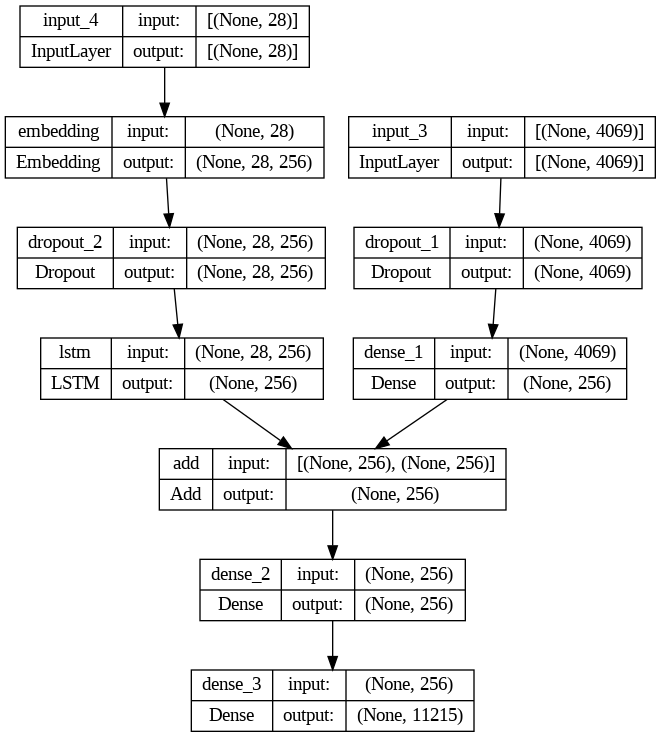

In [20]:
# ENCODER MODEL
# Image feature layers
inputs1 = Input(shape=(4069,)) # vgg output is 4069 features
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# DECODER MODEL
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# WHOLE MODEL
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')
# plot the model
plot_model(model, show_shapes=True)

# Model Training

In [21]:
epochs = 20
batch_size = 64
steps = len(train) // batch_size

for i in range(epochs):
  # create data generator
  generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
  # fit for one epoch
  model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

In [22]:
# model.save(os.path.join(MODEL_DIR, 'model.h5'))

In [ ]:
model = tf.keras.models.load_model(os.path.join(MODEL_DIR, 'model.h5'))

# Generate Captions for Image

In [ ]:
def idx_to_word(integer, tokenizer):
  for word, index in tokenizer.word_index.items():
    if index == integer:
      return word
  return None

In [ ]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
  # add start tag for generation process
  in_text = 'startseq'
  # iterate over the max length of sequence
  for i in range(max_length):
    # encode input sequence
    sequence = tokenizer.texts_to_sequences([in_text])[0]
    # pad the sequence
    sequence = pad_sequences([sequence], max_length)
    # predict next word
    yhat = model.predict([image, sequence], verbose=0)
    # get index with highest probability
    yhat = np.argmax(yhat)
    # convert index to word
    word = idx_to_word(yhat, tokenizer)
    # stop if word not found
    if word is None:
      break
    # append word as input for generating next word
    in_text += ' ' + word
    # stop if we reach end tag
    if word == 'endseq':
      break
  return in_text

In [28]:
# validate with test data
actual, predicted = list(), list()

for key in test:
  # get actual caption
  captions = mapping[key]
  # predict the caption for image
  y_pred = predict_caption(model, features[key], tokenizer, max_length)

  # split into words
  actual_captions = [caption.split() for caption in captions]
  y_pred = y_pred.split()

  # append to the list
  actual.append(actual_captions)
  predicted.append(y_pred)

# calculate BLEU score (n-gram)
print(f'BLEU-1: {corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))}')
print(f'BLEU-2: {corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))}')
print(f'BLEU-3: {corpus_bleu(actual, predicted, weights=(0.334, 0.333, 0.333, 0))}')
print(f'BLEU-4: {corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))}')

BLEU-1: 0.4435
BLEU-2: 0.2562
BLEU-3: 0.1143
BLEU-4: 0.0842


# Visualize the Results

In [ ]:
def generate_caption(image_name):
  image_id = image_name.split('.')[0]

  with ZipFile(os.path.join(DATASET_DIR, 'flickr8.zip'), 'r') as zip:
    data = zip.open(os.path.join('Images', image_name))
    image = Image.open(data)

    captions = mapping[image_id]
    print('-------------------Actual-------------------')
    for caption in captions:
      print(caption)

    print()
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('-------------------Predicted-------------------')
    print(y_pred)
    print()
    plt.imshow(image)

-------------------Actual-------------------
startseq كلاب بيضاء تلعب على الشاطئ endseq
startseq اثنين من الكلاب يلعبون معا على الشاطئ endseq
startseq اثنين من الكلاب تلعب على طول الشاطئ الرملي endseq

-------------------Predicted-------------------
startseq اثنين من الكلاب تلعب في الثلج endseq



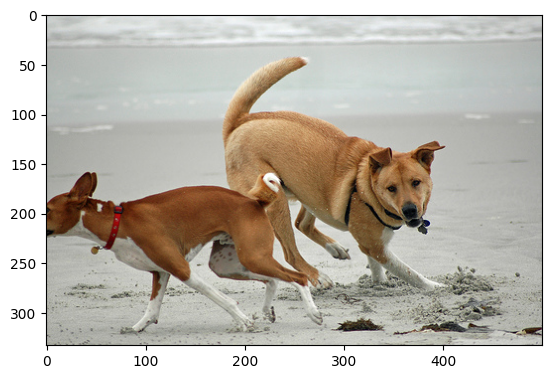

In [ ]:
image_name = f'{train[20]}.jpg'

generate_caption(image_name)